# House price analysis

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Accessing data

In [2]:
dir_grl = '/workspaces/accesibilidad-urbana/data/processed/costo-vivienda/'

In [28]:
years = [2019,2020,2021]
sheet = 'Renta'
gdf = gpd.GeoDataFrame()

for year in years:
    gdf_tmp = gpd.read_file(dir_grl+f'{year}_{sheet}_PrecioVivienda_AMG_OC22_GCS_v1.geojson',
          driver='GeoJSON')
    
    gdf_tmp['year'] = year
    
    gdf = pd.concat([gdf, gdf_tmp], ignore_index = True, axis = 0)
    
print(gdf.shape)
gdf.head(2)

(17823, 8)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year
0,Departamento,7000.0,Guadalajara,LAS TORRES,-103.379569,20.651848,POINT (-103.37957 20.65185),2019
1,Casa,15000.0,Tlajomulco,BOSQUE REAL DE SANTA ANITA,-103.493673,20.567822,POINT (-103.49367 20.56782),2019


<AxesSubplot:>

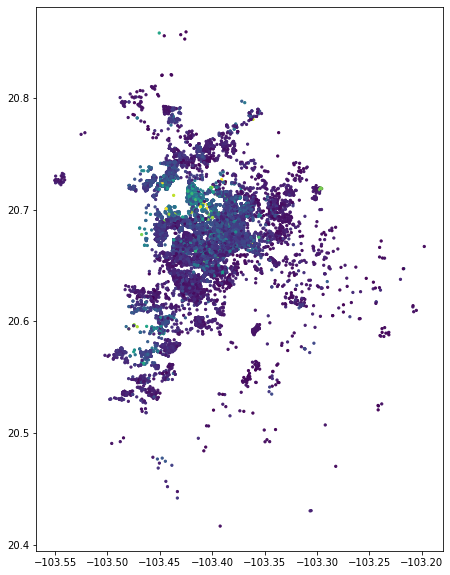

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot('Precio', markersize=5, ax=ax)

## Analysis by square footage

In [5]:
idx = gdf['Metros cuadrados de construcción'].isna()
gdf_sq = gdf[~idx].copy()
gdf_sq = gdf_sq.loc[gdf['Metros cuadrados de construcción']>0].copy()
print(gdf_sq.shape)

(33262, 10)


<AxesSubplot:>

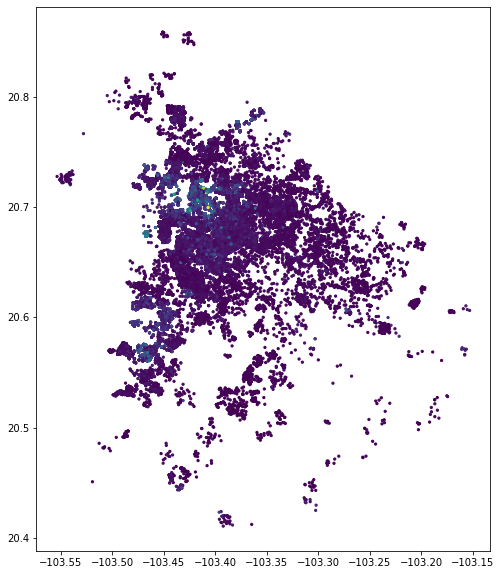

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_sq.plot('Precio', markersize=5, ax=ax)

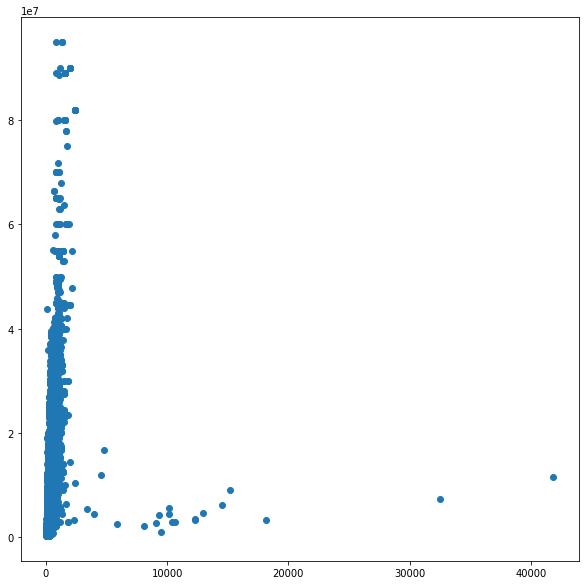

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=gdf_sq['Metros cuadrados de construcción'],
            y=gdf_sq['Precio'])

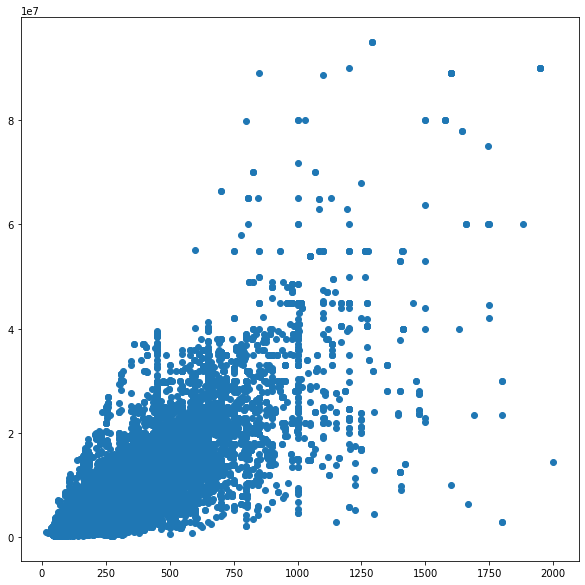

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=gdf_sq.loc[gdf_sq['Metros cuadrados de construcción']<=2000,'Metros cuadrados de construcción'],
            y=gdf_sq.loc[gdf_sq['Metros cuadrados de construcción']<=2000,'Precio'])

### $ / m²

In [31]:
gdf_sq['$_sq_m'] = gdf_sq['Precio'] / gdf_sq['Metros cuadrados de construcción']

In [32]:
from scipy import stats

z = np.abs(stats.zscore(gdf_sq['$_sq_m']))

gdf_sq[z < 3].shape

(32863, 11)

In [33]:
gdf_sq = gdf_sq[z < 3].copy()

In [34]:
gdf_sq['$_sq_m'].mean()

27240.156678154002

In [35]:
gdf_sq['$_sq_m'].std()

13391.248901541783

In [36]:
gdf_sq['$_sq_m'].median()

24657.534246575342

In [37]:
gdf_sq['$_sq_m'].max()

72222.22222222222

In [38]:
gdf_sq['$_sq_m'].min()

118.1559236206351

<AxesSubplot:>

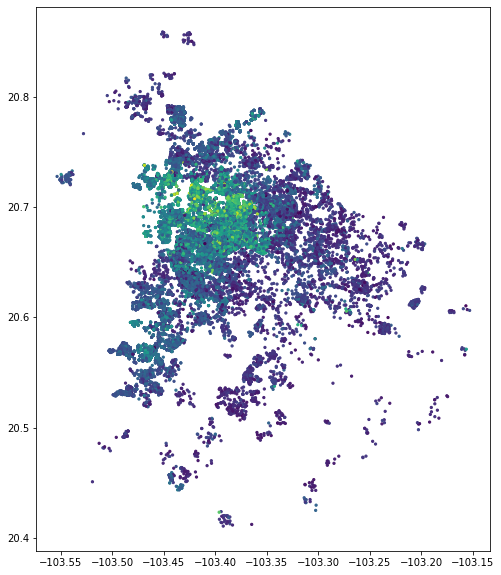

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_sq.plot('$_sq_m', markersize=5, ax=ax)

Text(0, 0.5, 'Precio de venta')

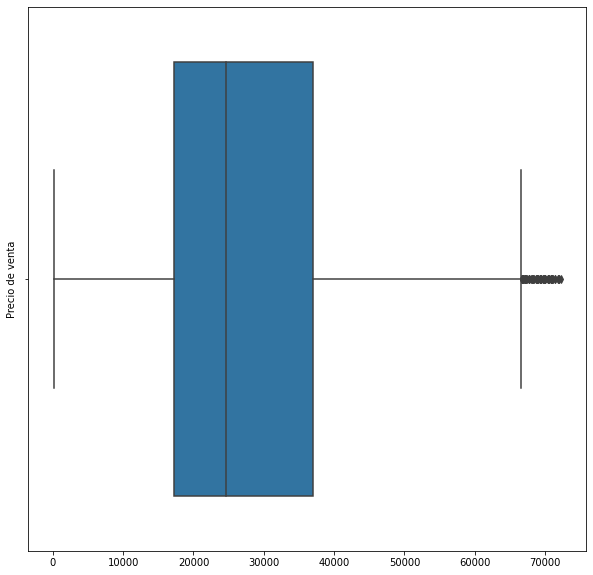

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

# x = np.array(gdf_sq['Metros cuadrados de construcción'])
y = np.array(gdf_sq['$_sq_m'])

sns.boxplot(x=y, ax=ax)

plt.ylabel('Precio de venta')

In [ ]:
g = sns.displot(data=hex_pdf, x="T_Pob_10_20", kind="kde",
           height=10, aspect=2)
g.refline(x = 0,
          color = "black",
         lw = 1)

## Hex Grid

In [20]:
c = 'Guadalajara'
res = 8
folder = 'hexgrid'
table = f'hexgrid_{res}_city'

query = f"SELECT * FROM {folder}.{table} WHERE \"metropolis\" LIKE \'{c}\'"
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_gdf.shape)
hex_gdf.head(2)

(4095, 4)


,geometry,hex_id_8,CVEGEO,metropolis
0,"POLYGON ((-103.60989 20.39686, -103.61044 20.4...",8849abc91bfffff,14002,Guadalajara
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,Guadalajara


## Merging data

In [21]:
point_hex = gpd.sjoin(gdf_sq, hex_gdf)
print(point_hex.shape)
point_hex.head(2)

(33247, 15)


,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,hex_id_8,CVEGEO,metropolis
9297,Casa,470234.0,GUADALAJARA,PARQUES DEL NILO I,-103.287175,20.649130,POINT (-103.28718 20.64913),2020,75.0,95.0,4949.831579,3057,88498c9711fffff,14039,Guadalajara
9588,Casa,470234.0,GUADALAJARA,PARQUES DEL NILO I,-103.288460,20.649398,POINT (-103.28846 20.64940),2020,85.0,120.0,3918.616667,3057,88498c9711fffff,14039,Guadalajara


In [22]:
point_hex_group = point_hex.groupby(f'hex_id_{res}').count()
point_hex_group.head(5)

,Inmueble,Precio,Municipio,Colonia,x,y,geometry,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m,index_right,CVEGEO,metropolis
hex_id_8,,,,,,,,,,,,,,
88498c8649fffff,6,6,6,6,6,6,6,6,6,6,6,6,6,6
88498c864bfffff,1,1,1,1,1,1,1,1,1,1,1,1,1,1
88498c8659fffff,1,1,1,1,1,1,1,1,1,1,1,1,1,1
88498c865bfffff,44,44,44,44,44,44,44,44,44,44,44,44,44,44
88498c9015fffff,3,3,3,3,3,3,3,3,2,3,3,3,3,3


In [23]:
points_by_hex = 5
point_h_g_filter = point_hex_group[point_hex_group['Inmueble']>points_by_hex].copy()
point_h_g_filter = point_hex[point_hex[f'hex_id_{res}'].isin(list(point_h_g_filter.index))]

In [24]:
point_for_join = gpd.GeoDataFrame()

for hex_id in list(point_h_g_filter[f'hex_id_{res}'].unique()):
    
    gdf_tmp = point_h_g_filter.loc[point_h_g_filter[f'hex_id_{res}']==hex_id].sample(points_by_hex)
    
    point_for_join = pd.concat([point_for_join, gdf_tmp], ignore_index = True, axis = 0)
    
print(point_for_join.shape)

(2825, 15)


In [25]:
point_for_join.drop(columns=['index_right',f'hex_id_{res}'], inplace=True)

In [26]:
hex_price = aup.group_by_hex_mean(point_for_join, hex_gdf, res, '$_sq_m', osmid=False)
hex_price = hex_price.loc[hex_price.Precio>0].copy()
print(hex_price.shape)
hex_price.head(2)

(565, 11)


,geometry,hex_id_8,CVEGEO,metropolis,Precio,x,y,year,Metros cuadrados de terreno,Metros cuadrados de construcción,$_sq_m
490,"POLYGON ((-103.30257 20.56566, -103.29804 20.5...",8849aa2d89fffff,14070,Guadalajara,7150000.0,-103.305114,20.571592,2020.8,570.6,532.4,13702.042855
512,"POLYGON ((-103.32978 20.54731, -103.32524 20.5...",8849aa2c33fffff,14070,Guadalajara,762300.0,-103.333162,20.554803,2021.0,89.2,79.6,9517.476623


<AxesSubplot:>

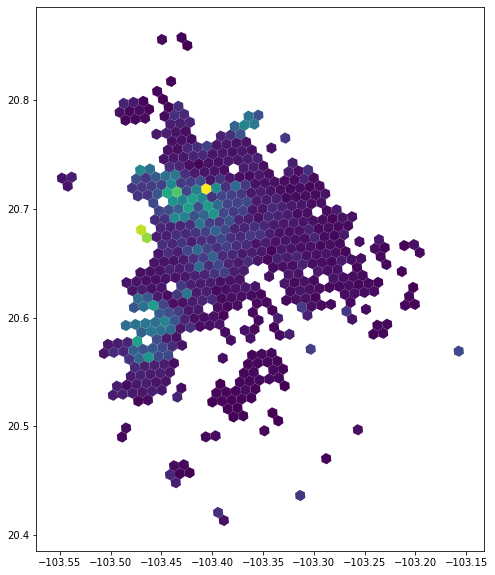

In [27]:
_, ax = plt.subplots(figsize=(10,10))
hex_price.plot('Precio', markersize=5, ax=ax)

In [57]:
dir_grl = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Costo_Vivienda/Medio_Urbano/Costo_Vivienda/'
hex_price.to_file(dir_grl+f'PrecioVivienda_HexRes{res}_AMG_OC22_GCS_v1.geojson',
          driver='GeoJSON')